In [1]:
import os
import time
import random
import numpy as np
from tqdm.auto import tqdm

import cv2
from PIL import Image
from matplotlib import pyplot as plt

# 爬蟲用的
import base64
import urllib
import requests
from io import BytesIO
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

In [2]:
class DataGenerator():
    def __init__(self, root_path, module, driver_path):
        self.root_path = root_path
    
        self.module = module
        
    def get_idol_faces(self, keyword):
        
        image_path = os.path.join(self.root_path, keyword)
        if os.path.exists(image_path):
            pass
        else:
            os.mkdir(image_path)
          
        google_search_url = 'https://www.google.com/search?q={0}&site=webhp&tbm=isch'.format(keyword)
        
        chrome_options = Options() 
        chrome_options.add_argument('--headless')   #無頭模式
        driver = webdriver.Chrome(driver_path, options=chrome_options)
        print('Begin Searching...')
        driver.get(google_search_url)
        # 模擬滾輪
        for _ in range(7):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(3)
            
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        driver.close()
        print('Checking Search results...')
        cnt = 0
        for img in tqdm(soup.find_all('img')):
            get_src = img.get('src', 'None') 
            # 結果的格式分為 url 以及 base64
            if get_src.startswith('http'):
                image = self.url_to_image(get_src)

            elif get_src.startswith('data:image'):
                image = self.base64_to_image(get_src)
            # 只抓臉 其他不要
            catch_result = self.catch_face(image)
            if catch_result is not None:
                save_path = os.path.join(image_path, '{0}.jpg'.format(cnt))
                # 解決 cv2.imwrite 路徑不能用中文
                # 把圖片案jpg格式編碼 return (status, 編碼)
                cv2.imencode('.jpg', catch_result)[1].tofile(save_path)
                cnt += 1
     
        print('Download Completed, there are {0} available images.'.format(cnt))
        return self
    
    def base64_to_image(self, base):
        base64_file = base64.b64decode(base.split(',')[1])
        image_data = BytesIO(base64_file)
        image = np.asarray(Image.open(image_data), dtype=np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        return image

    def url_to_image(self, url):
        # download the image, convert it to a NumPy array, and then read
        # it into OpenCV format
        resp = urllib.request.urlopen(url)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        return image

    def catch_face(self, img):
        #列出資料集所有圖片
        
        #detectMultiScale(image, scaleFactor, minNeighbors, flags, minSize, maxSize)
        #scaleFactor 每次縮小比例
        #minNeighbors至 少要被檢測到幾次才算是真的目標
        #minSize, maxSize 目標最小最大尺寸
        faces = self.module.detectMultiScale(img, 1.3, 5)
        #只找抓到一個臉的
        if len(faces) == 1:
            x, y, w, h = faces[0]
            crop_img = img[y:y+h, x:x+w]
            
            return crop_img                            
        
        return None

In [3]:
root_path = os.getcwd()
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
driver_path = r'C:\Users\andy.cgt\Downloads\chromedriver.exe'
data_generator = DataGenerator(root_path, face_cascade, driver_path)

In [4]:
data_generator.get_idol_faces('鬼娃恰吉')
data_generator.get_idol_faces('王世堅')
print('OK')

Begin Searching...
Checking Search results...



Download Completed, there are 157 available images.
Begin Searching...
Checking Search results...



Download Completed, there are 286 available images.
OK


In [5]:
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [6]:
class ImageFolder(Dataset):
    
    def __init__(self, Y0_dir, Y1_dir, transform=None):
        self.Y0 = glob.glob(os.path.join(Y0_dir, '*.jpg'))
        self.Y1 = glob.glob(os.path.join(Y1_dir, '*.jpg'))
        
        self.files = self.Y0 + self.Y1
        self.labels = [0] * len(self.Y0) + [1] * len(self.Y1)
        self.transform = transform
    
    def __getitem__(self, index):
        img = Image.open(self.files[index])
        label = self.labels[index]
        
        if self.transform is not None:
            return self.transform(img), label
        else:
            return img, label

    def __len__(self):
        return len(self.files)

In [7]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [8]:
class Resnet(nn.Module):
    def __init__(self, num_filters):
        super().__init__()
        
        self.models = nn.Sequential(nn.ReflectionPad2d(2),
                                    nn.Conv2d(num_filters, num_filters, kernel_size=5, stride=1, padding=0),
                                    nn.InstanceNorm2d(num_filters),
                                    nn.ReLU(True),
                                    nn.ReflectionPad2d(3),
                                    nn.Conv2d(num_filters, num_filters, kernel_size=7, stride=1, padding=0),
                                    nn.InstanceNorm2d(num_filters))
        
    def forward(self, x):
        x = x + self.models(x) 
        return x

In [9]:
class CNN_MODEL(nn.Module):
    def __init__(self, input_dim=3 , num_filters=16, n_blocks=6):
        super().__init__()
        
        self.models = nn.ModuleList([nn.ReflectionPad2d(4),
                                     nn.Conv2d(input_dim, num_filters, kernel_size=9, stride=1, padding=0)])
        for i in range(n_blocks):
            self.models.append(Resnet(num_filters))
            
        self.models.extend([nn.ReflectionPad2d(1),
                            nn.Conv2d(num_filters, 1, kernel_size=3, stride=1, padding=0),
                            nn.MaxPool2d(4),
                            Flatten(),
                            nn.Linear(16*16, 128),
                            nn.Linear(128, 32),
                            nn.Linear(32, 2),
                            nn.Softmax(1)])
            
    def forward(self, x):
        for layer in self.models:
            x = layer(x)
        return x

In [10]:
TRAIN_SIZE = 0.8
BATCH_SIZE = 10
N_EPOCHES = 20
LR_RATE = 0.0003
WEIGHT_DECAY = 0.00001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', DEVICE)

Current device: cuda


In [11]:
transform = transforms.Compose([transforms.Resize((64, 64)), 
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

In [12]:
dataset = ImageFolder(Y0_dir='王世堅', Y1_dir='鬼娃恰吉', transform=transform)
train_len = int(len(dataset) * TRAIN_SIZE)
test_len = len(dataset) - train_len
train, test = random_split(dataset, [train_len, test_len])

In [13]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
model = CNN_MODEL(input_dim=3 , num_filters=16, n_blocks=3).to(DEVICE)
criterion = nn.CrossEntropyLoss()#(weight=torch.FloatTensor([1., 3.]).to(DEVICE))
optimizer = optim.Adam(model.parameters(), lr=LR_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=15)

In [15]:
for epo in tqdm(range(N_EPOCHES)):
    model.train()
    for imgs, targets in train_loader:
        imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
        outputs = model(imgs)
        
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        torch.cuda.empty_cache()
        
    model.eval()
    with torch.no_grad():
        training_loss = 0
        training_acc = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            outputs = model(imgs)

            training_loss += criterion(outputs, targets).item()
            training_acc += (outputs.argmax(dim=1) == targets).sum().cpu().numpy()
        
        testing_loss = 0
        testing_acc = 0
        for imgs, targets in test_loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            outputs = model(imgs)

            testing_loss += criterion(outputs, targets).item()
            testing_acc += (outputs.argmax(dim=1) == targets).sum().cpu().numpy()
    print_sent = 'Epoch {0:2d}/{1} : training_loss: {2:.4f}, training_acc: {3:.2f}, testing_loss: {4:.4f}, testing_acc: {5:.2f}'
    print(print_sent.format(epo+1, N_EPOCHES, training_loss, training_acc/train_len, testing_loss, testing_acc/test_len))

    

Epoch  1/20 : training_loss: 12.7652, training_acc: 0.95, testing_loss: 3.0806, testing_acc: 0.98
Epoch  2/20 : training_loss: 12.3507, training_acc: 0.97, testing_loss: 3.1223, testing_acc: 0.97
Epoch  3/20 : training_loss: 12.5654, training_acc: 0.96, testing_loss: 3.2199, testing_acc: 0.96
Epoch  4/20 : training_loss: 12.1958, training_acc: 0.97, testing_loss: 3.1234, testing_acc: 0.97
Epoch  5/20 : training_loss: 12.2447, training_acc: 0.97, testing_loss: 3.1962, testing_acc: 0.96
Epoch  6/20 : training_loss: 12.2466, training_acc: 0.97, testing_loss: 3.2591, testing_acc: 0.94
Epoch  7/20 : training_loss: 12.3155, training_acc: 0.97, testing_loss: 3.2182, testing_acc: 0.96
Epoch  8/20 : training_loss: 11.8644, training_acc: 0.98, testing_loss: 3.0633, testing_acc: 0.98
Epoch  9/20 : training_loss: 12.1552, training_acc: 0.97, testing_loss: 3.3555, testing_acc: 0.94
Epoch 10/20 : training_loss: 11.8218, training_acc: 0.98, testing_loss: 3.2276, testing_acc: 0.96
Epoch 11/20 : traini

In [19]:
def face_plot(model, picture, name_dic):
    #設定字體
    font = cv2.FONT_HERSHEY_COMPLEX
    #顏色順序RGB
    im = Image.open(picture)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
    #顏色順序BGR
    img = cv2.imread(picture)
    #return x,y 起點 w:x方向寬 h:y方向高
    faces = face_cascade.detectMultiScale(img)

    for x,y,w,h in faces:
        box = (x, y, x+w, y+h)
        #裁剪 只把臉截出來 retrun 圖
        crpim = im.crop(box).resize((64,64))
        #圖轉array
        target_image = transform(crpim).unsqueeze(0)
   
        res = model(target_image.to(DEVICE)).cpu().detach().numpy()
        #cv2.rectangle(影像, 頂點座標, 對向頂點座標, 顏色, 線條寬度)  線條寬度若為負 代表實心
        #cv2.putText(影像, 文字, 座標, 字型, 大小, 顏色, 線條寬度, 線條種類)
        tag, color = name_dic[int(res.argmax(1))]
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)
        cv2.putText(img, tag, (x + int(w/3)-70, y-10), font, 0.5, color, 1)
    plt.figure(figsize=(30,20))
    #BGR to RGB
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [20]:
name_dic = {0: ["wang shi jian", (255,0,255)],
            1: ['chia ji', (14,201,255)]}
name_dic

{0: ['wang shi jian', (255, 0, 255)], 1: ['chia ji', (14, 201, 255)]}

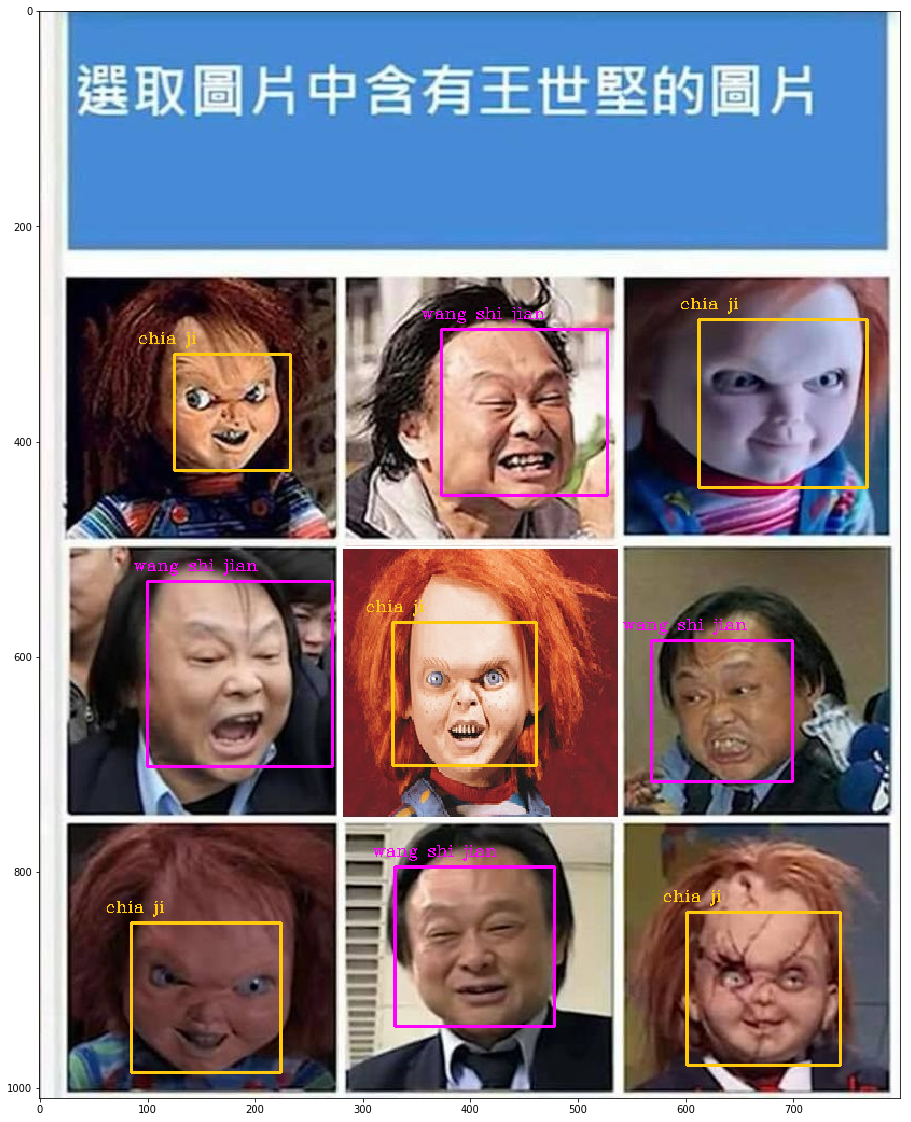

In [21]:
face_plot(model, 'chi.jpg', name_dic)